# Ideation



In [23]:
import yfinance as yf
import pandas as pd
from helper import get_tickers, get_extreme
from portfolio import MomentumPortfolio
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

lowess = sm.nonparametric.lowess



In [24]:
tickers = get_tickers()

# just use first one for ideation
data = pd.DataFrame(yf.Ticker(tickers[0]).history(period = "10y")["Close"])
data.head()


,Close
Date,
2016-02-04 00:00:00-05:00,43.079185
2016-02-05 00:00:00-05:00,42.361065
2016-02-08 00:00:00-05:00,41.667713
2016-02-09 00:00:00-05:00,41.436581
2016-02-10 00:00:00-05:00,41.428333


In [25]:
data["100dma"] = data[["Close"]].rolling("100D").mean()
data["100dms"] = data[["Close"]].rolling("100D").std()
data.tail()


,Close,100dma,100dms
Date,,,
2026-01-28 00:00:00-05:00,146.839996,141.101488,2.751172
2026-01-29 00:00:00-05:00,146.699997,141.223633,2.812865
2026-01-30 00:00:00-05:00,145.500000,141.336150,2.828837
2026-02-02 00:00:00-05:00,146.309998,141.474685,2.886548
2026-02-03 00:00:00-05:00,145.539993,141.534469,2.907032


In [26]:
data["z"] = (data["Close"] - data["100dma"])/data["100dms"]
data = data.dropna()
data.tail(5)
# higher z more expensive, lower z cheaper


,Close,100dma,100dms,z
Date,,,,
2026-01-28 00:00:00-05:00,146.839996,141.101488,2.751172,2.085842
2026-01-29 00:00:00-05:00,146.699997,141.223633,2.812865,1.946899
2026-01-30 00:00:00-05:00,145.500000,141.336150,2.828837,1.471930
2026-02-02 00:00:00-05:00,146.309998,141.474685,2.886548,1.675119
2026-02-03 00:00:00-05:00,145.539993,141.534469,2.907032,1.377874


Feature 1: z score of distance from 100dma

In [52]:
data["pct_return"] = data["Close"].pct_change()
data = data.dropna()

def get_smoothed_velocity(prices, dt=1.0):
    # Process Noise (Q) and Measurement Noise (R)
    # Tuning: Smaller Q = Smoother/Slower, Larger Q = Jittery/Fast
    q = 1e-2
    r = 1.0
    
    # State: [Position, Velocity]
    x = np.array([[prices.iloc[0]], [0.0]])
    P = np.eye(2)
    F = np.array([[1, dt],
                  [0, 1]])
    H = np.array([[1, 0]])
    Q = np.eye(2) * q
    R = np.array([[r]])
    
    smoothed_velocities = []
    
    for z in prices:
        # Prediction
        x = F @ x
        P = F @ P @ F.T + Q
        
        # Update
        y = z - (H @ x) # Innovation
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(2) - K @ H) @ P
        
        # We extract state[1] which is the 'hidden' velocity
        smoothed_velocities.append(x[1, 0])
        
    return np.array(smoothed_velocities)

data["smoothed_returns"] = get_smoothed_velocity(data["Close"])
data["diff"] = data["Close"].diff()
data[["smoothed_returns", "diff"]]


,smoothed_returns,diff
Date,,
2016-07-18 00:00:00-04:00,0.000000,NaN
2016-07-19 00:00:00-04:00,-0.075518,-0.225807
2016-07-20 00:00:00-04:00,-0.005308,0.275993
2016-07-21 00:00:00-04:00,-0.011776,-0.142181
2016-07-22 00:00:00-04:00,0.009737,0.150536
...,...,...
2026-01-28 00:00:00-05:00,0.324031,-0.220001
2026-01-29 00:00:00-05:00,0.322768,-0.139999
2026-01-30 00:00:00-05:00,0.200980,-1.199997


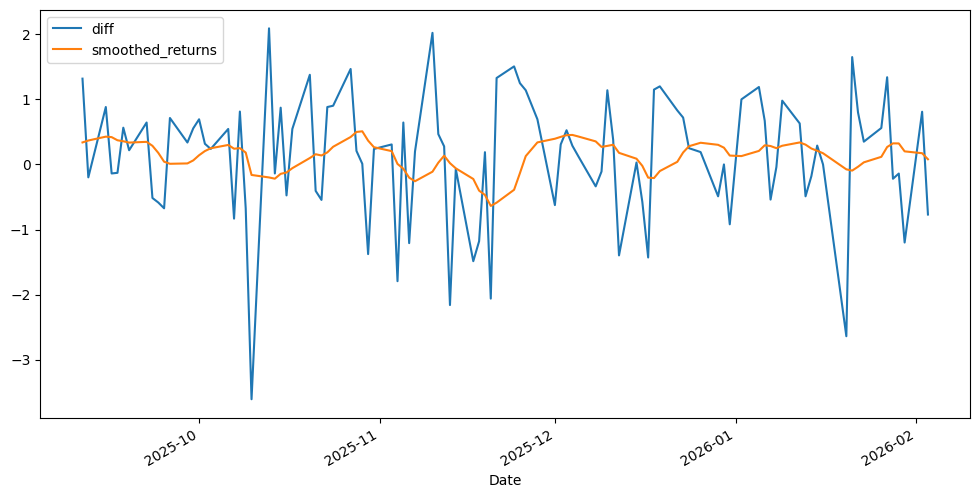

In [54]:
plt.figure(figsize=(12, 6))
ax = plt.gca() 
data.tail(100).plot(y = "diff", ax = ax)
data.tail(100).plot(y = "smoothed_returns", ax = ax)
plt.show()


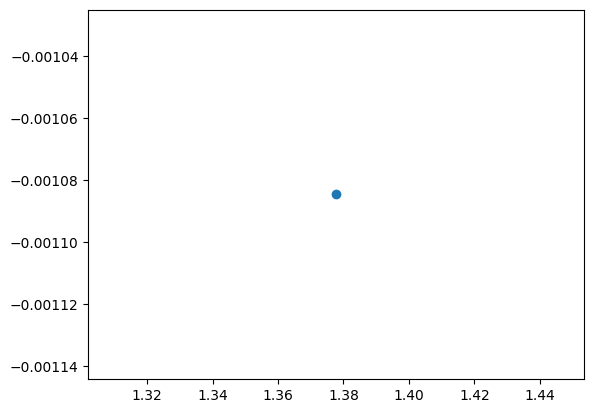

In [43]:
plt.scatter(x = data["z"].iloc[-1], y = data["smoothed_returns"].iloc[-1])

plt.show()


Lowess curve to find trend. 

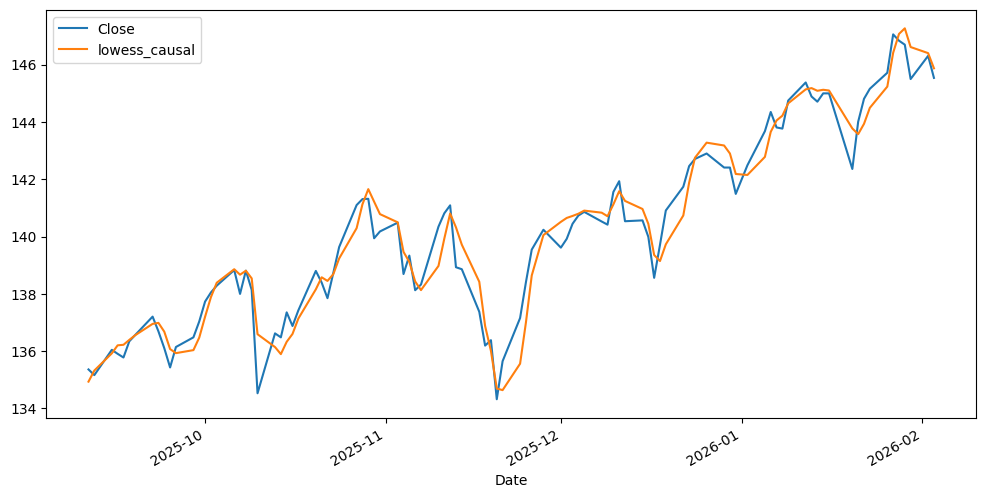

In [29]:
window_size = 100 

def get_causal_lowess(window):
    # This function takes the current window and returns ONLY the last smoothed point
    # frac=0.1 means it uses 10% of the window to smooth the final point
    res = lowess(window, np.arange(len(window)), frac=0.1, it=0)
    return res[-1, 1]  # Return the last smoothed value (the current day)

# 2. Apply it using a rolling window
# This ensures each 'lowess' value only knows about the past
data["lowess_causal"] = data["Close"].rolling(window=window_size).apply(get_causal_lowess)
data["lowess_gradient"] = np.gradient(data["lowess_causal"])
plt.figure(figsize=(12, 6))
ax = plt.gca() 
data.tail(100).plot(y = "Close", ax = ax)
data.tail(100).plot(y = "lowess_causal", ax = ax)
plt.show()


In [30]:
data.sample(5)


,Close,100dma,100dms,z,pct_return,smoothed_returns,lowess_causal,lowess_gradient
Date,,,,,,,,
2019-12-13 00:00:00-05:00,70.252426,67.201476,1.637979,1.862631,0.003179,0.165420,70.096022,0.407174
2021-12-22 00:00:00-05:00,97.291641,96.011333,1.978395,0.647145,0.009376,0.015677,96.350967,0.763918
2017-01-11 00:00:00-05:00,51.126022,49.305010,0.873115,2.085649,0.005478,0.106821,51.095720,0.033018
2024-03-12 00:00:00-04:00,105.345177,99.390799,2.996709,1.986973,0.010107,0.211875,105.042856,0.336655
2025-03-12 00:00:00-04:00,114.590424,118.307103,2.055305,-1.808334,0.005959,-0.561487,114.075267,-0.686837


In [31]:
get_extreme(data.tail(50))



(np.float64(147.05999755859375), 10)

So now two strats, one shorting when z is low and buying when z is high and other doing the opposite? How to implement percentage retracement

In [32]:
trade_data = data.dropna()
portfolio = MomentumPortfolio()
hist = []
trade_data = trade_data.reset_index()
for i in range(100, trade_data.shape[0]):
    curr_data = trade_data.iloc[i - 100: i]
    day = curr_data.iloc[-1]
    
    transaction = None
    if day["z"] < -2 and not portfolio.holding():
        extreme_price = get_extreme(curr_data)[0]
        transaction = portfolio.buy(day["Close"], 10, extreme_price)
    elif day["z"] > 2 and not portfolio.holding():
        extreme_price = get_extreme(curr_data)[0]
        transaction = portfolio.sell(day["Close"], 10, extreme_price)
    
    # Try to close position on each iteration
    close_result = portfolio.close(day["Close"])
    if close_result:
        transaction = close_result
    
    value = portfolio.get_value(day["Close"])
    hist.append([day["Date"], transaction, value])

hist = pd.DataFrame(hist, columns = ["Date", "Transaction", "Value"])


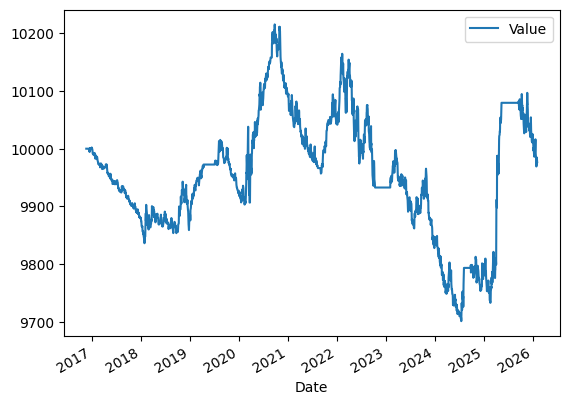

In [33]:
hist.plot(x = "Date", y = "Value")
plt.show()


In [34]:
hist["daily_return"] = hist["Value"].pct_change()
hist["daily_return"].mean()/hist["daily_return"].std() * np.sqrt(252)


np.float64(-0.013060149652218422)